# TEXT TO DISEASE! 📋➡️👨‍⚕️

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

2024-03-24 18:57:59.447117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 18:58:00.054854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'1.24.3'

In [5]:
df = pd.read_csv('datasets/Symptom2Disease.csv').iloc[:, 1:]
df.head()

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."


In [6]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

/tmp/ipykernel_7284/3039307885.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = df['label'], palette = 'Blues_d')


Text(0.5, 1.0, 'Count of each disease')

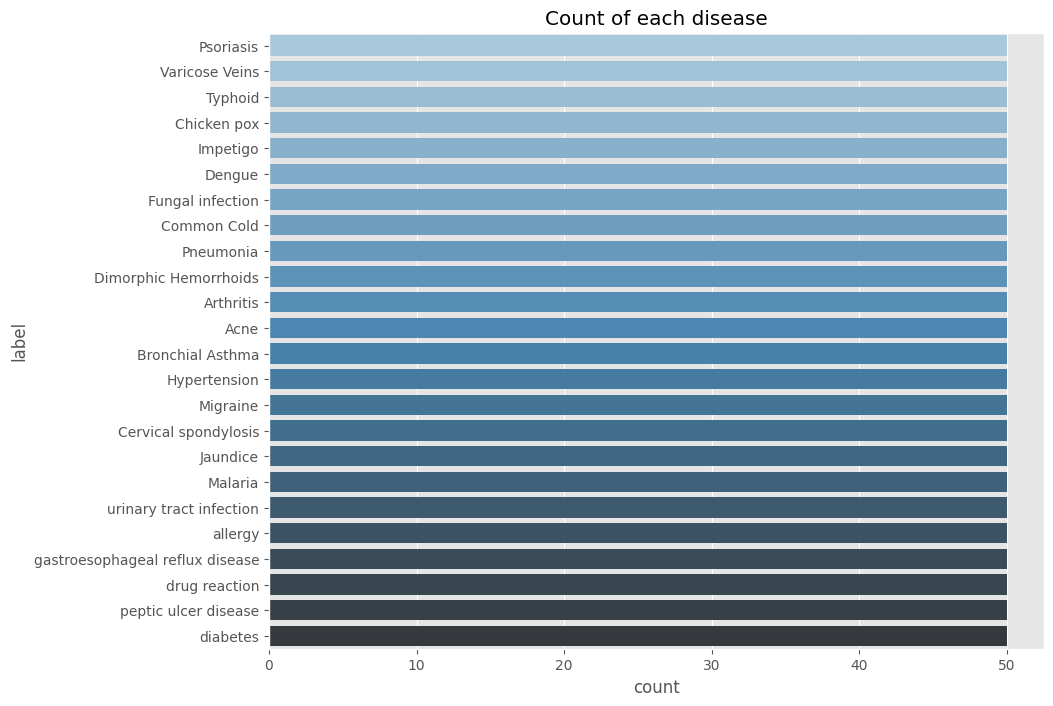

In [7]:
plt.figure(figsize = (10, 8))

sns.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

In [8]:
df['label'] = df['label'].map(lambda x: label2int[x]).astype("category")
df['text'] = df['text'].astype("str")

In [10]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 2414


In [11]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1080,), (120,), (1080,), (120,))

In [12]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)

/home/guayo/anaconda3/envs/HPE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
100%|██████████| 19/19 [00:03<00:00,  5.13it/s]
2024-03-24 18:59:30.549822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 18:59:30.652540: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU librarie

In [15]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7f42a438fd60> True
<keras.src.layers.regularization.dropout.Dropout object at 0x7f42a40f77c0> True
<keras.src.layers.core.dense.Dense object at 0x7f42a40b10d0> True


## Train the model!

In [17]:
EPOCHS = 3

history = model.fit(train_dataset, 
          epochs = EPOCHS, 
          validation_data = val_dataset)

Epoch 1/3


135/135 [==============================] - 1356s 10s/step - loss: 2.5821 - accuracy: 0.3694 - val_loss: 1.5279 - val_accuracy: 0.8500
Epoch 2/3
135/135 [==============================] - 1316s 10s/step - loss: 1.0748 - accuracy: 0.8593 - val_loss: 0.5723 - val_accuracy: 0.9500
Epoch 3/3
135/135 [==============================] - 1306s 10s/step - loss: 0.3841 - accuracy: 0.9833 - val_loss: 0.2494 - val_accuracy: 0.9667


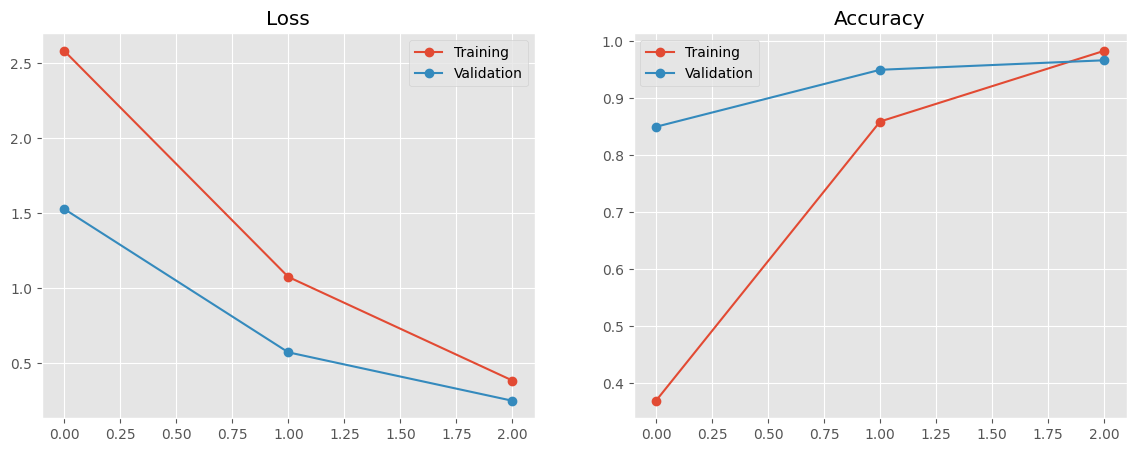

In [18]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Now it's ready to use!

In [19]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)

def predict_disease(text : str) -> str:
    return pipe(text)[0][:2]

In [20]:
text1 = "I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. "
text2 = "I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting \
    worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever."

In [21]:
print(predict_disease(text1))
print(predict_disease(text2))

[{'label': 'Psoriasis', 'score': 0.7760650515556335}, {'label': 'Fungal infection', 'score': 0.09203904867172241}]
[{'label': 'Typhoid', 'score': 0.8860639333724976}, {'label': 'Chicken pox', 'score': 0.017300717532634735}]


In [32]:
predict_disease("I have been smoking for 50 years, cigarretes, cigars, and all sorts of tobacco")

[{'label': 'peptic ulcer disease', 'score': 0.29949256777763367},
 {'label': 'gastroesophageal reflux disease', 'score': 0.1556379795074463}]